In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [2]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = CIFAR10(root='~/data',  train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testset = CIFAR10(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

print(len(train_dl), len(test_dl))

Files already downloaded and verified
Files already downloaded and verified
782 157


In [3]:
class BasicBlock(nn.Module):
    def __init__(self, channel_num):
        super(BasicBlock, self).__init__()
        self.conv_block1 = nn.Sequential(
			nn.Conv2d(channel_num, channel_num, 3, padding=1),
			nn.BatchNorm2d(channel_num),
			nn.ReLU(),
		)
        self.conv_block2 = nn.Sequential(
			nn.Conv2d(channel_num, channel_num, 3, padding=1),
			nn.BatchNorm2d(channel_num),
		)
        self.relu = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.conv_block1[0].weight)
        torch.nn.init.kaiming_normal_(self.conv_block2[0].weight)
        
    def forward(self, x):
        residual = x
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x + residual
        out = self.relu(x)
        return out

In [4]:
class BasicTransBlock(nn.Module):
    def __init__(self, channel_num):
        super(BasicTransBlock, self).__init__()
        self.conv_block1 = nn.Sequential(
			nn.ConvTranspose2d(channel_num, channel_num, 3, padding=1),
			nn.BatchNorm2d(channel_num),
			nn.ReLU(),
		)
        self.conv_block2 = nn.Sequential(
			nn.ConvTranspose2d(channel_num, channel_num, 3, padding=1),
			nn.BatchNorm2d(channel_num),
		)
        self.relu = nn.ReLU()
        torch.nn.init.kaiming_normal_(self.conv_block1[0].weight)
        torch.nn.init.kaiming_normal_(self.conv_block2[0].weight)
        
    def forward(self, x):
        residual = x
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x + residual
        out = self.relu(x)
        return out

In [5]:
class Cifar10_ResNetAE(nn.Module):
    def __init__(self, in_channels = 3, type = 18):
        super(Cifar10_ResNetAE, self).__init__()
        self.struc_dict = {
            18: {
                "num_channels" : [64, 128, 256, 512],
                "counts" : [2, 2, 2, 2]
            }
        }
        self.conv_in = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=7, stride=1)
        torch.nn.init.kaiming_normal_(self.conv_in.weight)
        self.max_in = nn.MaxPool2d(2)

        num_channels = self.struc_dict[type]["num_channels"]
        counts = self.struc_dict[type]["counts"]
        inv_num_channels = self.struc_dict[type]["num_channels"][::-1]
        
        self.encoder = nn.Sequential()
        for idx, struc in enumerate(
            zip(
                num_channels, 
                counts
            )
        ):
            num_channel, cnt = struc
            for i in range(cnt):
                self.encoder.add_module(f"conv{idx}_{i}", BasicBlock(num_channel))
            if idx < len(num_channels) - 1:
                self.encoder.add_module(
                    f"conv_switch{idx}_{idx+1}", nn.Conv2d(num_channel, num_channels[idx+1], 3, 1)
                )
                self.encoder.add_module(
                    f"bn{idx}_{idx+1}", nn.BatchNorm2d(num_channels[idx+1])
                )

        
        self.decoder = nn.Sequential()
        for idx, struc in enumerate(
            zip(
                inv_num_channels, 
                counts
            )
        ):
            num_channel, cnt = struc
            for i in range(cnt):
                self.decoder.add_module(f"deconv{idx}_{i}", BasicTransBlock(num_channel))
            if idx < len(inv_num_channels) - 1:
                self.decoder.add_module(
                    f"deconv_switch{idx}_{idx+1}", nn.ConvTranspose2d(num_channel, inv_num_channels[idx+1], 3, 1)
                )
                self.decoder.add_module(
                    f"bn{idx}_{idx+1}", nn.BatchNorm2d(inv_num_channels[idx+1])
                )

        self.up_out = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_out = nn.ConvTranspose2d(in_channels=64, out_channels=in_channels, kernel_size=7, stride=1)
        torch.nn.init.kaiming_normal_(self.conv_out.weight)
                                     
    def forward(self, x):
        x = self.conv_in(x)
        x = self.max_in(x)
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.up_out(x)
        x = self.conv_out(x)
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

epochs = 10

model = Cifar10_ResNetAE().to(device)

optimizer = Adam(model.parameters(), lr = 0.001)

scheduler = CosineAnnealingLR(optimizer, epochs)

loss_fn = nn.MSELoss()

In [7]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img = model(train_img)
        train_loss = loss_fn(gen_img, train_img)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img = model(valid_img)

            valid_loss = loss_fn(gen_img, valid_img)

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 69.98it/s]


Epoch: 0 - TrainLoss: 0.3942508882345141 - ValidLoss: 0.21038087775373154


100%|████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 68.07it/s]


Epoch: 1 - TrainLoss: 0.08648125493846585 - ValidLoss: 2.6839904643737587


100%|████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 68.41it/s]


Epoch: 2 - TrainLoss: 0.06579589336405477 - ValidLoss: 1.1208235199331857


100%|████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 69.68it/s]


Epoch: 3 - TrainLoss: 0.056283069598247935 - ValidLoss: 649.6905170572791


100%|████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 68.82it/s]


Epoch: 4 - TrainLoss: 0.05144176154833316 - ValidLoss: 0.24037034987549113


100%|████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 68.90it/s]


Epoch: 5 - TrainLoss: 0.04279186881011557 - ValidLoss: 1.71430016902222


100%|████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 68.73it/s]


Epoch: 6 - TrainLoss: 0.040641469835682446 - ValidLoss: 39.1139482753292


100%|████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 69.35it/s]


Epoch: 7 - TrainLoss: 0.03983311515892177 - ValidLoss: 0.10539929023024383


100%|████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 69.22it/s]


Epoch: 8 - TrainLoss: 0.036507445659078756 - ValidLoss: 0.1378904315316753


100%|████████████████████████████████████████████████████████████████████| 157/157 [00:02<00:00, 68.64it/s]

Epoch: 9 - TrainLoss: 0.03258836738136418 - ValidLoss: 0.05947129789051736


  0%|                                                                               | 0/10 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
 30%|█████████████████████▎                                                 | 3/10 [00:00<00:00, 24.81it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input d

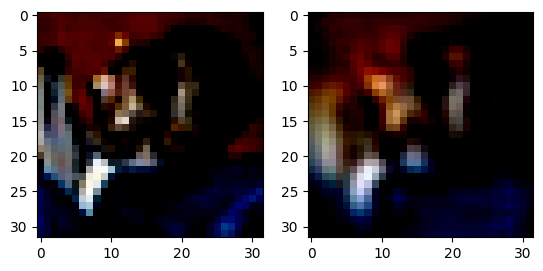

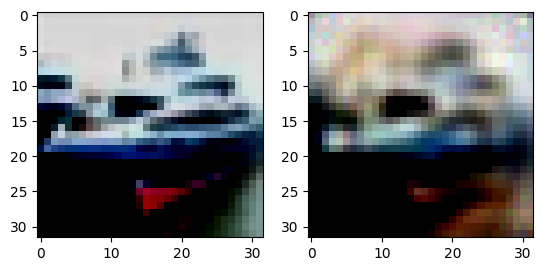

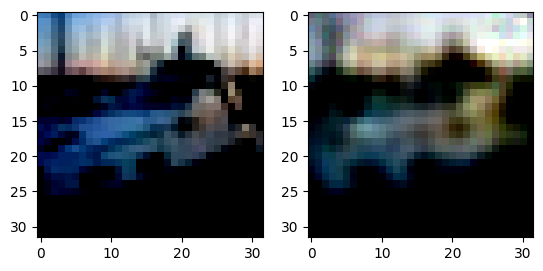

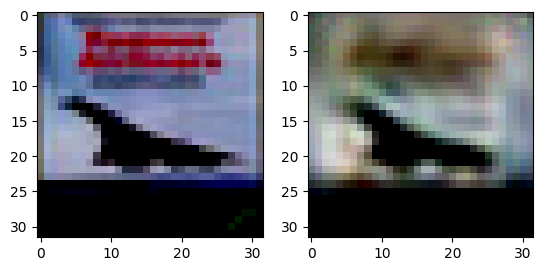

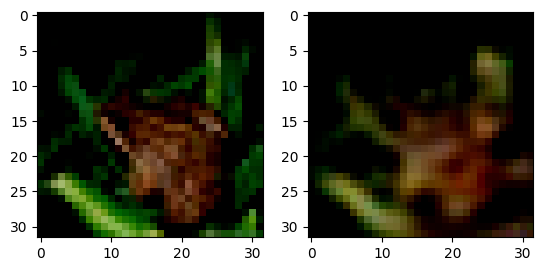

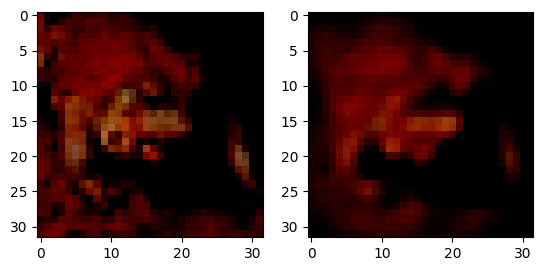

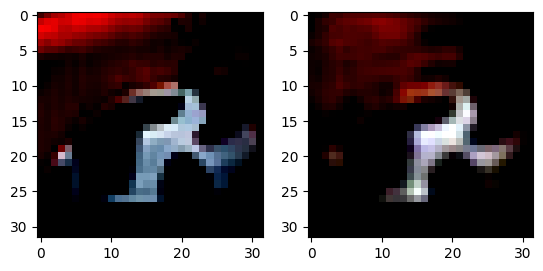

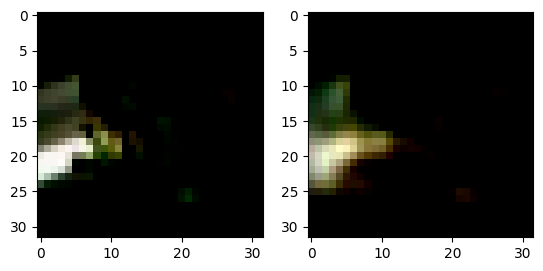

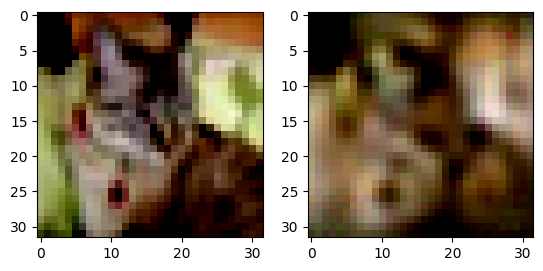

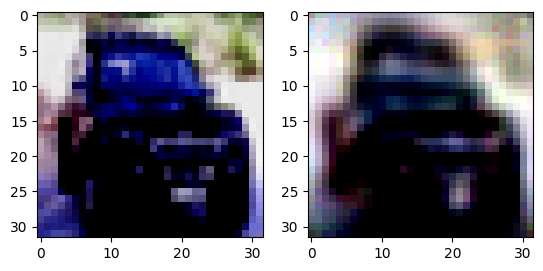

In [8]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img = model(valid_img)        

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())